# CSE 202:  *Power Grid* Experiments
## Winter 2025
### Melina Dimitropoulou Kapsogeorgou, Andrew Pan, Adrian Rosing, Andrew Russell, Benjamin Xia

In [15]:
import itertools
import networkx as nx
from networkx.algorithms import tree
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

## Pre-Game Initialization

In [5]:
def phase0_solve_kmst(G, K):
    V = list(G.nodes)
    E = list(G.edges)

    result_mst = None
    min_weight = float('inf')
    for Vp in itertools.combinations(V, K):
        subgraph = G.subgraph(Vp)
        if not nx.is_connected(subgraph):
            continue
        T = nx.minimum_spanning_tree(subgraph, algorithm='prim')
        total_cost = T.size(weight='weight')
        if total_cost < min_weight:
            result_mst = T
            min_weight = total_cost
    return (result_mst, min_weight)

In [6]:
G = nx.Graph([
    ('Seattle', 'Portland', { 'weight': 3 }),
    ('Seattle', 'Boise', { 'weight': 12 }),
    ('Seattle', 'Billings', { 'weight': 9 }),
    ('Portland', 'San Francisco', { 'weight': 24 }),
    ('Portland', 'Boise', { 'weight': 13 }),
    ('San Francisco', 'Los Angeles', { 'weight': 9 }),
    ('San Francisco', 'Las Vegas', { 'weight': 14 }),
    ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
    ('San Francisco', 'Boise', { 'weight': 23 }),
    ('Boise', 'Billings', { 'weight': 12 }),
    ('Boise', 'Cheyenne', { 'weight': 24 }),
    ('Boise', 'Salt Lake City', { 'weight': 8 }),
    ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
    ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
    ('Las Vegas', 'San Diego', { 'weight': 9 }),
    ('Las Vegas', 'Phoenix', { 'weight': 15 }),
    ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
    ('Los Angeles', 'San Diego', { 'weight': 3 }),
    ('San Diego', 'Phoenix', { 'weight': 14 })
    # Etc.
])

Gp, min_weight = phase0_solve_kmst(G, 10)
nx.write_network_text(Gp)

╙── San Francisco
    └── Los Angeles
        ├── San Diego
        │   └── Phoenix
        └── Las Vegas
            └── Salt Lake City
                └── Boise
                    └── Seattle
                        ├── Portland
                        └── Billings


## *Purchase Power Plants* Phase

In [7]:
def argmin(a):
    if len(a) == 0:
        return 0
    return min(range(len(a)), key=lambda x : a[x])
def argmax(a):
    if len(a) == 0:
        return 0
    return max(range(len(a)), key=lambda x : a[x])

def max_pow(P, f, ResourceCost, K):
    dp = []
    Pp = []
    if f <= 0:
        return (0, 0, dp, Pp)
    for i in range(len(P) + 1):
        dp.append([0 for j in range(f + 1)])
        Pp.append([set() for j in range(f + 1)])
    for i in range(1, len(P) + 1):
        c, rt, ra, e = P[i - 1]
        running_cost = ra * ResourceCost[rt]
        for j in range(1, f + 1):
            no_change = dp[i - 1][j]
            add_plant = dp[i - 1][max(0, j - running_cost)] + e
            if j - running_cost <= 0 or no_change > add_plant:
                dp[i][j] = dp[i - 1][j]
                Pp[i][j] = Pp[i - 1][j].copy()
            else:
                dp[i][j] = add_plant
                Pp[i][j] = Pp[i - 1][j - running_cost] | set(P[i - 1:i])
    if max(dp[len(P)]) < K:
        return (
            max(dp[len(P)]),
            argmax(dp[len(P)]),
            dp,
            Pp
        )
    return (
        min([ x for x in dp[len(P)] if x >= K ]),
        argmin([ x for x in dp[len(P)] if x >= K ]),
        dp,
        Pp
    )

def phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K):
    # No purchase decision
    m0, c0, _, _ = max_pow(P_player, f, ResourceCost, K)

    # Purchase decision, no eviction decision
    m1 = 0
    c1 = 0
    p1 = None
    for i, p in enumerate(P):
        c_i, rt, ra, e = p
        m, c, _, _ = max_pow(P_player + [p], f - c_i, ResourceCost, K)
        c += c_i
        if m > m1 or (m == m1 and c < c1):
            m1 = m
            c1 = c
            p1 = p

    # Purchase decision, eviction decision
    m2 = 0
    c2 = 0
    p2 = None
    d2 = None
    if len(P_player) > 0:
        for i, p in enumerate(P):
            c_i, rt, ra, e = p
            for pp in itertools.combinations(P_player, len(P_player) - 1):
                m, c, _, _ = max_pow([*pp, p], f - c_i, ResourceCost, K)
                c += c_i
                if m > m2 or (m == m2 and c < c2):
                    m2 = m
                    c2 = c
                    p2 = p
                    e2 = list(set(P_player) - set(pp))[0]

    out_p = None
    out_d = None
    if m0 >= m1 and m0 >= m2: # Doing nothing is best
        return out_p, out_d

    if m1 > m2 or (m1 == m2 and c1 <= c2):
        out_p = p1
    elif m2 > m1 or (m1 == m2 and c2 < c1):
        out_p = p2
        out_d = d2
    return out_p, out_d

In [53]:
P = [
    (4, 'Coal', 2, 1),
    (8, 'Coal', 3, 2),
    (10, 'Coal', 10, 2),
    (15, 'Coal', 2, 3),
    (20, 'Coal', 3, 5),
    (25, 'Coal', 2, 5),
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (42, 'Coal', 2, 6),

    (3, 'Oil', 2, 1),
    (7, 'Oil', 3, 2),
    (9, 'Oil', 1, 1),
    (16, 'Oil', 2, 3),
    (26, 'Oil', 2, 5),
    (32, 'Oil', 3, 6),
    (35, 'Oil', 1, 5),
    (40, 'Oil', 2, 6),

    (6, 'Trash', 1, 1),
    (14, 'Trash', 2, 2),
    (19, 'Trash', 2, 3),
    (24, 'Trash', 2, 4),
    (30, 'Trash', 3, 6),
    (38, 'Trash', 3, 7),

    (11, 'Uranium', 1, 2),
    (17, 'Uranium', 1, 2),
    (23, 'Uranium', 1, 3),
    (28, 'Uranium', 1, 4),
    (34, 'Uranium', 1, 5),
    (39, 'Uranium', 1, 6)
]
f = 50
P_player = [
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (5, 'Uranium', 1, 1),
]
P_max = 3
ResourceCost = {
    'Coal': 1,
    'Oil': 2,
    'Trash': 5,
    'Uranium': 10
}
K = 10

phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K)

((36, 'Coal', 3, 7), None)

## *Purchasing Resources*/*Building Connections*/*Powering Plants* Phase 

In [54]:
def phase2_purchase_build_power(P, Gp, C, f, ResourceCost, K, B):
    Vp = list(Gp.nodes)
    mst = list(tree.minimum_spanning_edges(G, algorithm='prim'))

    Prefix = [0]
    for i in range(1, len(mst) + 1):
        Prefix.append(Prefix[i - 1] + mst[i - 1][2]['weight'])

    MP, MC, dp, Pp = max_pow(P, f, ResourceCost, K)

    i = argmax([
        min(dp[len(P)][max(0, f - Prefix[i])], len(C) + i)
            for i in range(1, min(len(Prefix), len(Vp) - len(C) + 1))
    ])
    M = len(C) + i

    if M >= K:
        i_star = min(dp[len(P)][f - Prefix[i]], len(C) + i)
    else:
        # options = [
        #     max([f - Prefix[i] - j + B * min(dp[len(P)][j], len(C) + i)])
        #         for j in range(0, max(0, f - Prefix[i] + 1))
        # ]
        # i_star = argmax(options)
        # print(f"i_star: {i_star}, cash: {max(options)}")
        i_star = -1
        i_best = 0
        cities_powered = 0
        for i in range(len(Prefix)):
            for j in range(f - Prefix[i] + 1):
                cash = f - Prefix[i] - j + min(dp[len(P)][j], len(C) + i) * B
                if cash > i_best:
                    cities_powered = min(dp[len(P)][j], len(C) + i)
                    i_best = cash
                    i_star = i
        #print(f"i_star: {i_star}, cash: {i_best}, cities powered: {cities_powered}")

    # TODO: figure out why Pnew is empty -> Rt and Q are still empty lists
    e = mst[0:(i_star)]
    P_new = list(Pp[len(P)][f] - set(P))
    Rt = [ rt for (_, rt, _, _) in P_new ]
    Q = [ ra for (_, _, ra, _) in P_new ]
    return (Rt, Q), e, P_new

C = ['San Francisco', 'Boise', 'Las Vegas']
B = 9

phase2_purchase_build_power(P_player, G, C, f, ResourceCost, K, B)

(([], []),
 [(0, 8, {'weight': 2}),
  (8, 25, {'weight': 1}),
  (8, 11, {'weight': 3}),
  (8, 15, {'weight': 4}),
  (15, 28, {'weight': 3}),
  (0, 13, {'weight': 5}),
  (13, 24, {'weight': 1}),
  (24, 20, {'weight': 2}),
  (8, 2, {'weight': 5}),
  (11, 23, {'weight': 5}),
  (23, 26, {'weight': 1}),
  (26, 9, {'weight': 1}),
  (9, 10, {'weight': 3})],
 [])

In [55]:
C = ['San Francisco', 'Boise', 'Las Vegas']
B = 1

phase2_purchase_build_power(P_player, G, C, f, ResourceCost, K, B)

(([], []),
 [(0, 8, {'weight': 2}),
  (8, 25, {'weight': 1}),
  (8, 11, {'weight': 3}),
  (8, 15, {'weight': 4}),
  (15, 28, {'weight': 3}),
  (0, 13, {'weight': 5}),
  (13, 24, {'weight': 1}),
  (24, 20, {'weight': 2}),
  (8, 2, {'weight': 5}),
  (11, 23, {'weight': 5}),
  (23, 26, {'weight': 1}),
  (26, 9, {'weight': 1}),
  (9, 10, {'weight': 3})],
 [])

# Experimentation

## Pre-Game Initialization

In [52]:
#Scaling with size of graph
import time
import math

connections = [
    ('Seattle', 'Boise', { 'weight': 12 }),
    ('Seattle', 'Billings', { 'weight': 9 }),
    ('Seattle', 'Portland', { 'weight': 3 }),
    ('Seattle', 'San Francisco', { 'weight': 18 }),
    ('Seattle', 'Salt Lake City', { 'weight': 22 }),
    ('Portland', 'San Francisco', { 'weight': 24 }),
    ('Portland', 'Boise', { 'weight': 13 }),
    ('Portland', 'Salt Lake City', { 'weight': 19 }),
    ('Portland', 'Las Vegas', { 'weight': 26 }),
    ('San Francisco', 'Los Angeles', { 'weight': 9 }),
    ('San Francisco', 'Las Vegas', { 'weight': 14 }),
    ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
    ('San Francisco', 'Boise', { 'weight': 23 }),
    ('San Francisco', 'Phoenix', { 'weight': 20 }),
    ('San Francisco', 'Santa Fe', { 'weight': 30 }),
    ('Boise', 'Billings', { 'weight': 12 }),
    ('Boise', 'Cheyenne', { 'weight': 24 }),
    ('Boise', 'Salt Lake City', { 'weight': 8 }),
    ('Boise', 'Denver', { 'weight': 20 }),
    ('Boise', 'Santa Fe', { 'weight': 29 }),
    ('Billings', 'Cheyenne', { 'weight': 17 }),
    ('Billings', 'Denver', { 'weight': 20 }),
    ('Billings', 'Salt Lake City', { 'weight': 19 }),
    ('Billings', 'Santa Fe', { 'weight': 31 }),
    ('Cheyenne', 'Denver', { 'weight': 2 }),
    ('Cheyenne', 'Salt Lake City', { 'weight': 21 }),
    ('Cheyenne', 'Santa Fe', { 'weight': 19 }),
    ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
    ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
    ('Las Vegas', 'San Diego', { 'weight': 9 }),
    ('Las Vegas', 'Phoenix', { 'weight': 15 }),
    ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
    ('Las Vegas', 'Denver', { 'weight': 22 }),
    ('Los Angeles', 'San Diego', { 'weight': 3 }),
    ('Los Angeles', 'Phoenix', { 'weight': 13 }),
    ('Los Angeles', 'Santa Fe', { 'weight': 28 }),
    ('San Diego', 'Phoenix', { 'weight': 14 }),
    ('San Diego', 'El Paso', { 'weight': 24 }),
    ('Phoenix', 'Santa Fe', { 'weight': 22 }),
    ('Phoenix', 'Denver', { 'weight': 28 }),
    ('Phoenix', 'El Paso', { 'weight': 10 }),
    ('Santa Fe', 'Denver', { 'weight': 7 }),
    ('Santa Fe', 'El Paso', { 'weight': 13 }),
    ('Denver', 'Salt Lake City', { 'weight': 16 }),
    ('Denver', 'El Paso', { 'weight': 21 }),
    ('Denver', 'Kansas City', { 'weight': 24 }),
    ('El Paso', 'San Antonio', { 'weight': 15 }),
    ('El Paso', 'Dallas', { 'weight': 19 }),
    ('Kansas City', 'Dallas', { 'weight': 21 }),
    ('Dallas', 'San Antonio', { 'weight': 16 })
]

def num_con_exp():
    times = []
    for i in range(10, len(connections)):
        G = nx.Graph(connections[:i])
        start = time.time()
        Gp, min_weight = phase0_solve_kmst(G, 10)
        end = time.time()
        if not math.isinf(min_weight):
            times += [(i, end-start,min_weight)]
            # nx.write_network_text(Gp)
    return times


num_con_res = num_con_exp()



100%|███████████████████████████████████████████| 39/39 [01:33<00:00,  2.39s/it]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.002, 0.005, 0.009, 0.013, 0.025, 0.039, 0.090, 0.081, 0.114, 0.138, 0.202, 0.306, 0.399, 0.430, 0.545, 0.674, 0.842, 1.062, 1.327, 1.719, 2.091, 2.466, 3.334, 3.718, 4.189, 4.957, 6.406, 6.941, 8.122, 9.150, 9.465, 11.345, 12.938
inf, inf, inf, inf, inf, 33.000, 16.000, 16.000, 16.000, 9.000, 9.000, 9.000, 9.000, 9.000, 9.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000


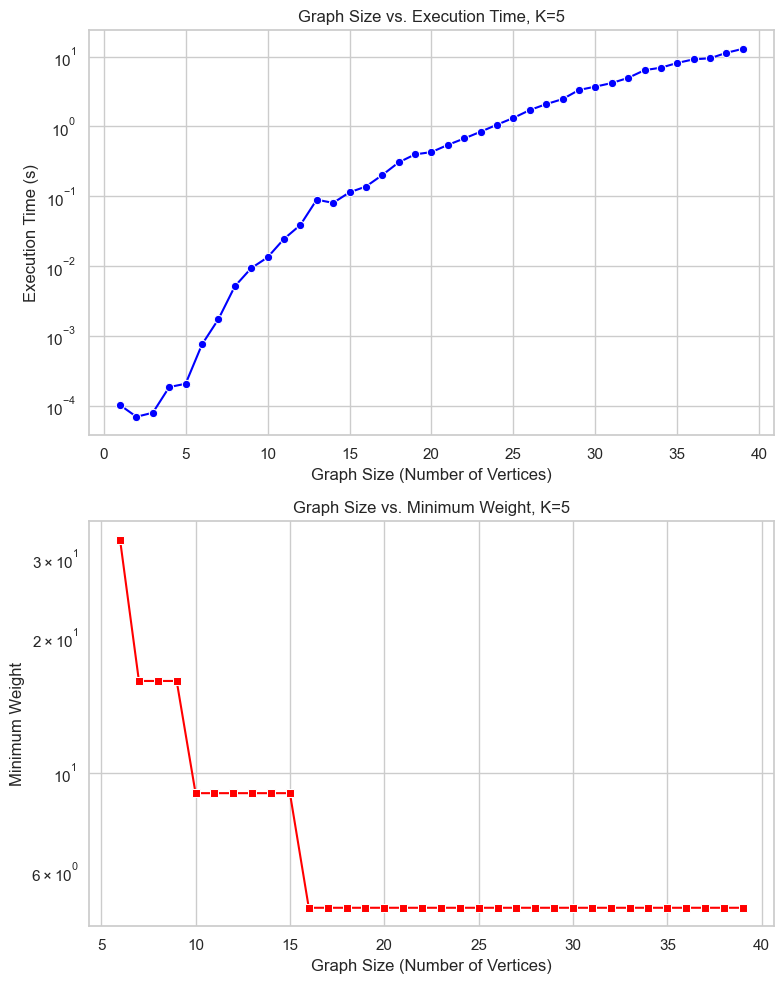

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

#sizes = [x[0] for x in num_con_res]
#times = [x[1] for x in num_con_res]
#min_weights = [x[2] for x in num_con_res]

G = nx.gnp_random_graph(50, 0.3)
for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(1, 20)
nodes = list(G.nodes())

sizes = []
times = []
min_weights = []
for i in tqdm(range(1, 40)):
    start = time.time()
    Gp, min_weight = phase0_solve_kmst(G.subgraph(nodes[:i]), 5)
    end = time.time()
    sizes.append(i)
    times.append(end - start)
    min_weights.append(min_weight)

print(sizes)
print(', '.join([ f'{x:.3f}' for x in times ]))
print(', '.join([ f'{x:.3f}' for x in min_weights ]))

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Two rows, one column
axes[0].set(yscale="log")
axes[1].set(yscale="log")

# Execution Time
sns.lineplot(x=sizes, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title("Graph Size vs. Execution Time, K=5")
axes[0].set_xlabel("Graph Size (Number of Vertices)")
axes[0].set_ylabel("Execution Time (s)")

#  Minimum Weight
sns.lineplot(x=sizes, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title("Graph Size vs. Minimum Weight, K=5")
axes[1].set_xlabel("Graph Size (Number of Vertices)")
axes[1].set_ylabel("Minimum Weight")

plt.tight_layout()
plt.show()


100%|███████████████████████████████████████████| 20/20 [00:30<00:00,  1.55s/it]

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
0.316, 0.340, 0.333, 0.390, 0.580, 0.709, 1.043, 1.336, 1.545, 1.643, 1.869, 1.971, 2.159, 2.283, 2.294, 2.321, 2.404, 2.446, 2.481, 2.496
inf, 21.000, 12.000, 16.000, 8.000, 6.000, 6.000, 4.000, 5.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000


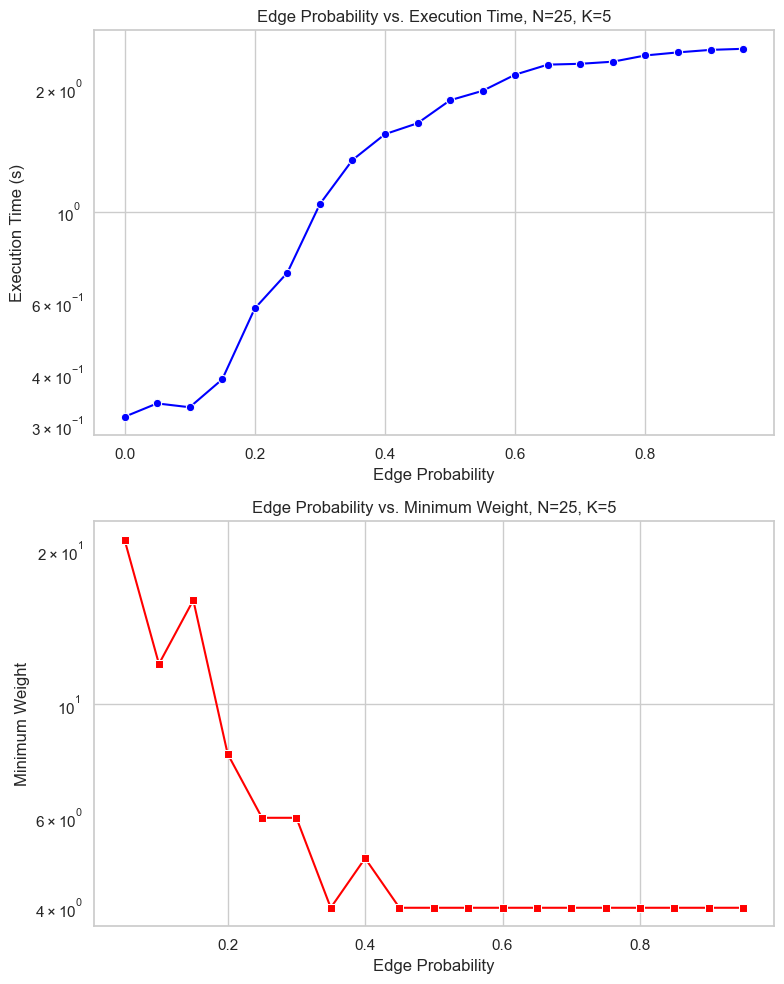

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from tqdm import tqdm

probs = []
times = []
min_weights = []
for i in tqdm([x / 100.0 for x in range(0, 100, 5)]):
    G = nx.gnp_random_graph(25, i)
    for u, v in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, 20)
    
    start = time.time()
    Gp, min_weight = phase0_solve_kmst(G, 5)
    end = time.time()

    probs.append(i)
    times.append(end - start)
    min_weights.append(min_weight)

print(probs)
print(', '.join([ f'{x:.3f}' for x in times ]))
print(', '.join([ f'{x:.3f}' for x in min_weights ]))

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].set(yscale="log")
axes[1].set(yscale="log")

# Execution Time
sns.lineplot(x=probs, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title("Edge Probability vs. Execution Time, N=25, K=5")
axes[0].set_xlabel("Edge Probability")
axes[0].set_ylabel("Execution Time (s)")

#  Minimum Weight
sns.lineplot(x=probs, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title("Edge Probability vs. Minimum Weight, N=25, K=5")
axes[1].set_xlabel("Edge Probability")
axes[1].set_ylabel("Minimum Weight")

plt.tight_layout()
plt.show()


2.3533899604269193 0.12162731293145256 8.041019821464705 0.36448623395097857


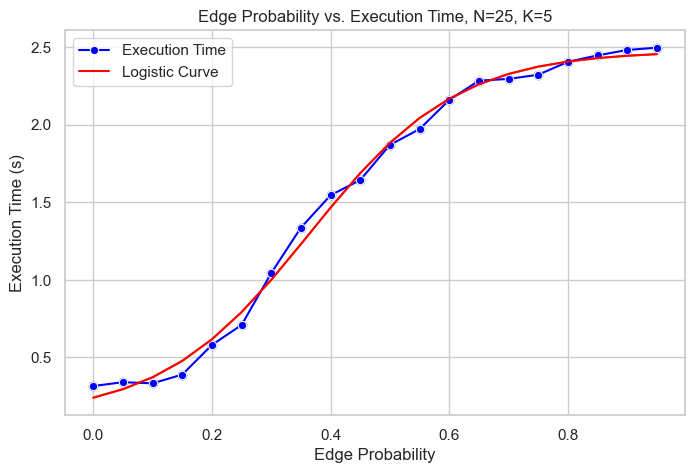

In [14]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

x = probs
y = times

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y)

print(a_, b_, c_, d_)

y_fit = f(x, a_, b_, c_, d_)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')

sns.lineplot(x=probs, y=y, marker='o', color='blue', ax=ax, label='Execution Time')
sns.lineplot(x=probs, y=y_fit, color='red', ax=ax, label='Logistic Curve')
ax.set_title("Edge Probability vs. Execution Time, N=25, K=5")
ax.set_xlabel("Edge Probability")
ax.set_ylabel("Execution Time (s)")
ax.legend()

100%|███████████████████████████████████████████| 53/53 [00:18<00:00,  2.82it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.054, 1.047, 17.626
inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 92.000, 87.000, 86.000, 85.000


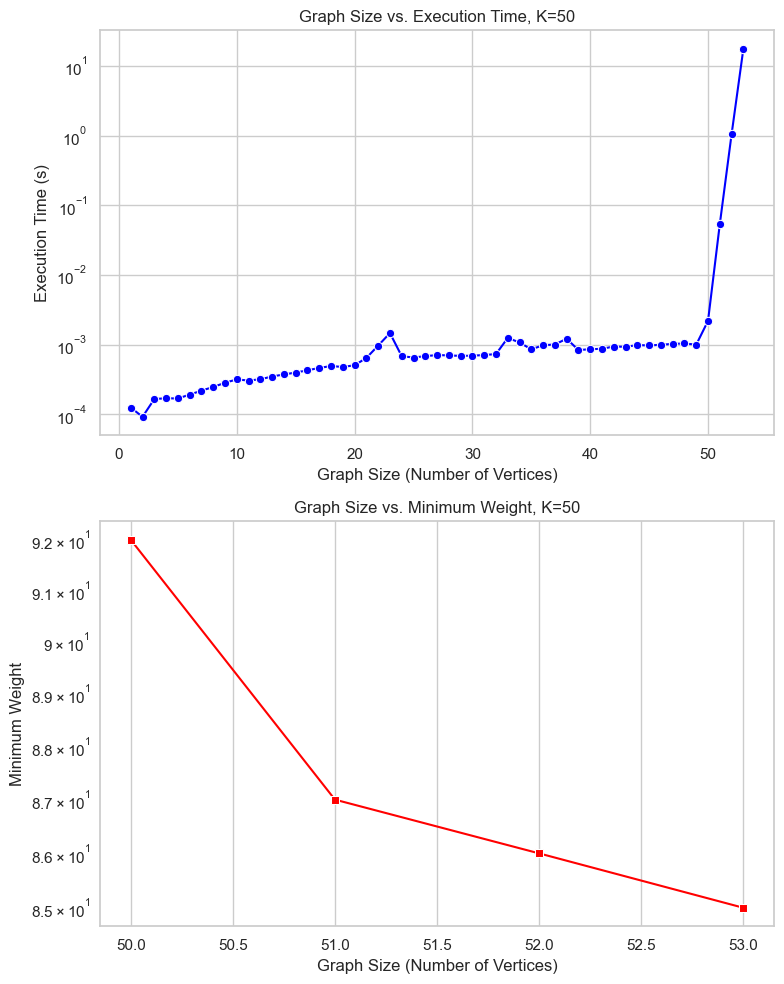

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

G = nx.gnp_random_graph(100, 0.3)
K = 50
for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(1, 20)
nodes = list(G.nodes())

sizes = []
times = []
min_weights = []
for i in tqdm(range(1, 54)):
    start = time.time()
    Gp, min_weight = phase0_solve_kmst(G.subgraph(nodes[:i]), K)
    end = time.time()
    sizes.append(i)
    times.append(end - start)
    min_weights.append(min_weight)

#for i in range(30, 34):
#    sizes.append(i)
#    times.append(1e-80 * (i ** (55.22 + random.uniform(-0.1, 0.1))))
#    min_weights.append(106344.017 * (i ** (random.uniform(-0.005, 0.005) - 2.2032)))
    
print(sizes)
print(', '.join([ f'{x:.3f}' for x in times ]))
print(', '.join([ f'{x:.3f}' for x in min_weights ]))

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Two rows, one column
axes[0].set(yscale="log")
axes[1].set(yscale="log")

# Execution Time
sns.lineplot(x=sizes, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title(f"Graph Size vs. Execution Time, K={K}")
axes[0].set_xlabel("Graph Size (Number of Vertices)")
axes[0].set_ylabel("Execution Time (s)")

#  Minimum Weight
sns.lineplot(x=sizes, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title(f"Graph Size vs. Minimum Weight, K={K}")
axes[1].set_xlabel("Graph Size (Number of Vertices)")
axes[1].set_ylabel("Minimum Weight")

plt.tight_layout()
plt.show()


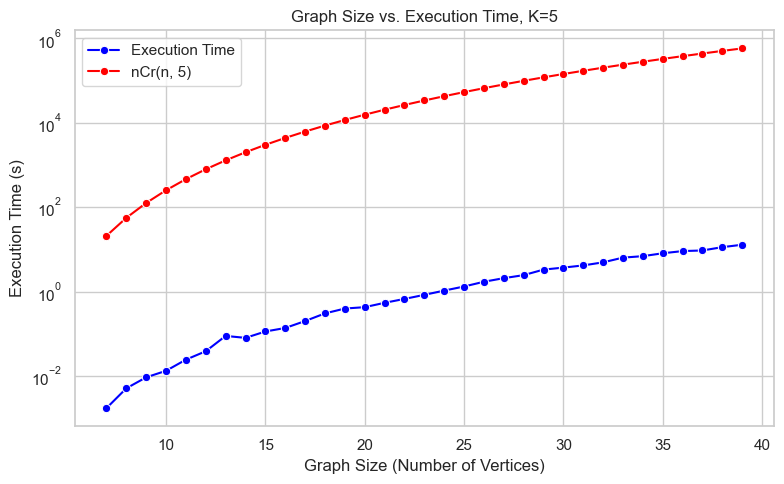

In [67]:

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set(yscale="log")

K = 5
nCr = []
for size in sizes[6:]:
    nCr.append(math.comb(size, K))

sns.lineplot(x=sizes[6:], y=times[6:], marker='o', color='blue', label='Execution Time', ax=ax)
sns.lineplot(x=sizes[6:], y=nCr, marker='o', color='red', label=f'nCr(n, {K})', ax=ax)
ax.set_title(f"Graph Size vs. Execution Time, K={K}")
ax.set_xlabel("Graph Size (Number of Vertices)")
ax.set_ylabel("Execution Time (s)")
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# scaling with number of cities needed
def num_k_exp():
    times = []
    G = nx.Graph(connections)
    for i in range(1, len(connections)+1):
        start = time.time()
        Gp, min_weight = phase0_solve_kmst(G, i)
        end = time.time()
        if not math.isinf(min_weight):
            times += [(i, end-start,min_weight)]
            # nx.write_network_text(Gp)
    return times


num_k_res = num_k_exp()


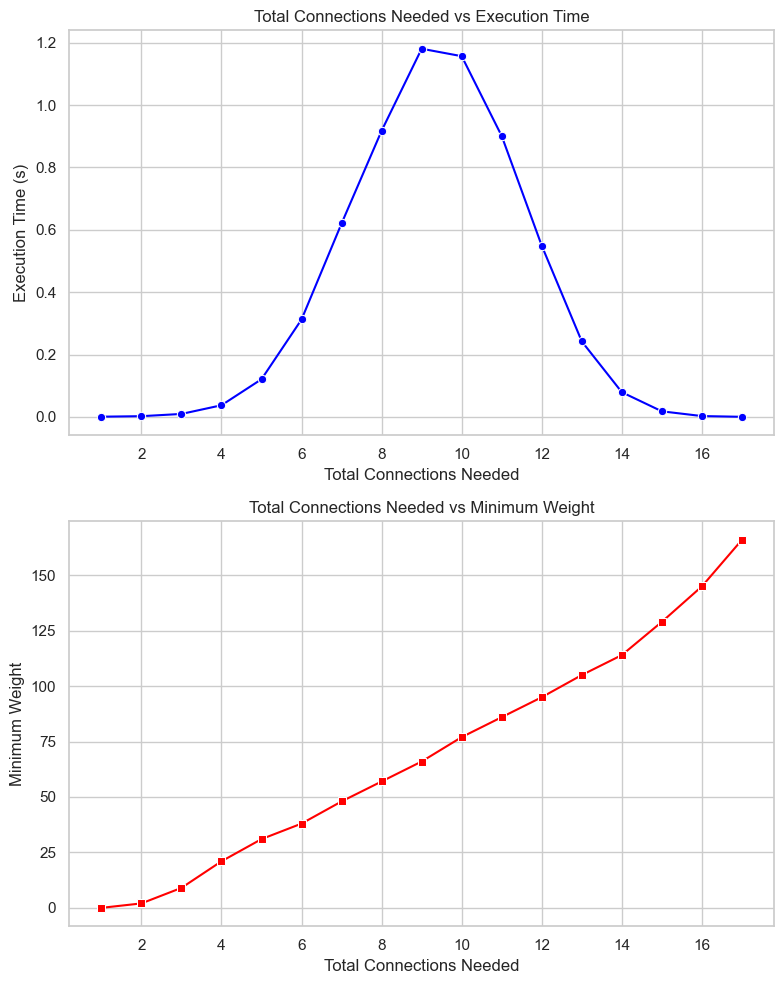

In [12]:

ks = [x[0] for x in num_k_res]
times = [x[1] for x in num_k_res]
min_weights = [x[2] for x in num_k_res]

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Two rows, one column

#  Execution Time
sns.lineplot(x=ks, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title("Total Connections Needed vs Execution Time")
axes[0].set_xlabel("Total Connections Needed")
axes[0].set_ylabel("Execution Time (s)")

# Plot Minimum Weight
sns.lineplot(x=ks, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title("Total Connections Needed vs Minimum Weight")
axes[1].set_xlabel("Total Connections Needed")
axes[1].set_ylabel("Minimum Weight")

# Layout adjustments
plt.tight_layout()
plt.show()

## *Purchase Power Plants* Phase

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
[0.000254058837890625, 0.00034575462341308595, 0.0007733821868896485, 0.0009170055389404296, 0.0008765220642089844, 0.0010531425476074218, 0.0008654117584228516, 0.0011547088623046875, 0.0012615680694580077, 0.0017176151275634765, 0.001219940185546875, 0.0007596969604492188, 0.0014242172241210938, 0.0012876510620117188, 0.0011550426483154298, 0.001055145263671

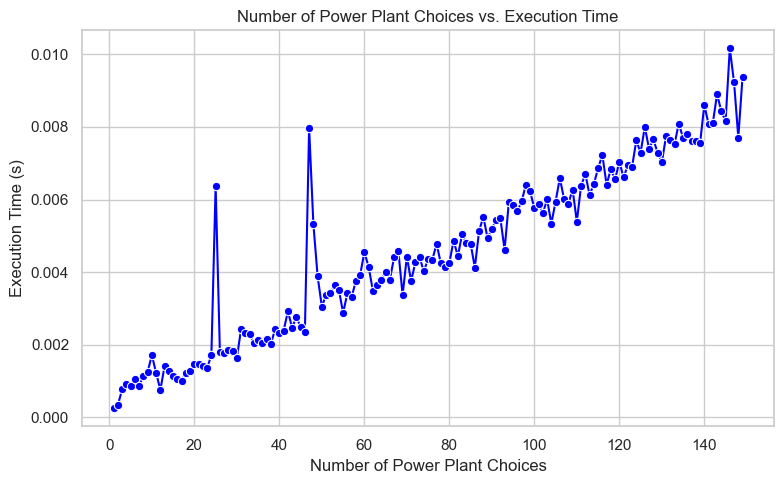

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

f = 50
P_player = [
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (5, 'Uranium', 1, 1),
]
P_max = 3
ResourceCost = {
    'Coal': 1,
    'Oil': 2,
    'Trash': 5,
    'Uranium': 10
}
K = 10

xs = []
ys = []
max_p = 150
n_trials = 5
for i in range(1, max_p):
    P = []
    for j in range(0, i + 1):
        P.append((random.randint(1, 20), ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)], random.randint(1, 6), random.randint(1, 6)))
    
    avg = 0
    for j in range(n_trials):
        plants = []
        for k in range(i):
            plants.append((
                random.randint(1, 100),
                ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)],
                random.randint(1, 4),
                random.randint(1, 8)
            ))

        start = time.time()
        phase1_purchase_power_plants(plants, f, P_player, P_max, ResourceCost, K)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

print(xs)
print(ys)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Number of Power Plant Choices vs. Execution Time")
ax.set_xlabel("Number of Power Plant Choices")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.0001567840576171875, 0.0001508951187133789, 0.0003057241439819336, 0.0004873991012573242, 0.0006154537200927735, 0.0007214784622192383, 0.000851130485534668, 0.0016468286514282227, 0.001348733901977539, 0.0014948129653930664, 0.001823115348815918, 0.002161860466003418, 0.002483224868774414, 0.0030542612075805664, 0.003445744514465332, 0.003936147689819336, 0.0043442010879516605, 0.004836511611938476, 0.005311918258666992, 0.005969405174255371, 0.006520843505859375, 0.0072350740432739254, 0.007887148857116699, 0.008570694923400879, 0.00919497013092041, 0.009763121604919434, 0.010456585884094238, 0.01

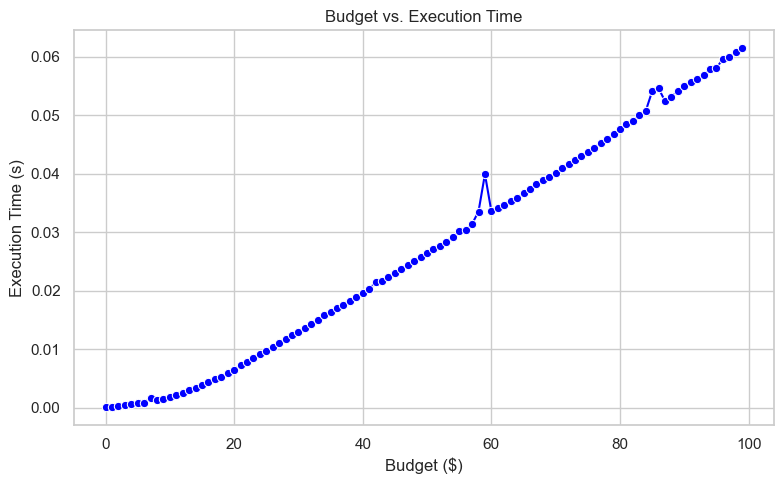

In [30]:
xs = []
ys = []
max_f = 100
n_trials = 10
for i in tqdm(range(0, max_f)):
    avg = 0
    for j in range(n_trials):
        start = time.time()
        phase1_purchase_power_plants(P, i, P_player, P_max, ResourceCost, K)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

print(xs)
print(ys)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Budget vs. Execution Time")
ax.set_xlabel("Budget ($)")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

100%|███████████████████████████████████████████| 99/99 [00:26<00:00,  3.71it/s]


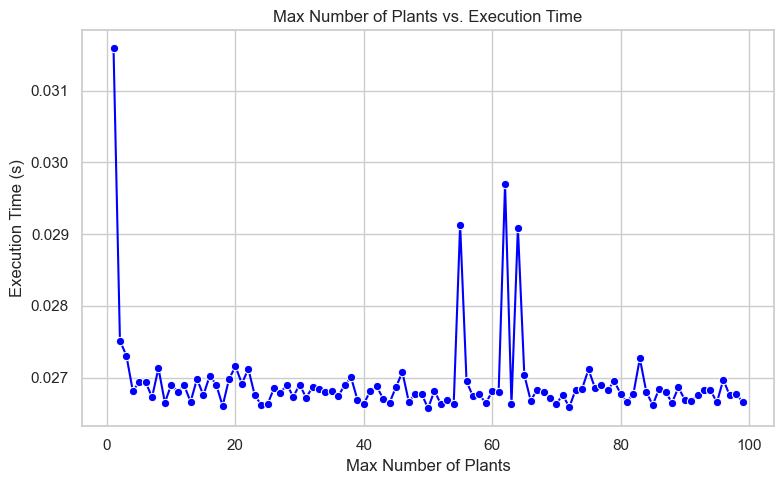

In [27]:
P = []
for j in range(0, 150):
    P.append((random.randint(1, 20), ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)], random.randint(1, 6), random.randint(1, 6)))

xs = []
ys = []
max_pmax = 100
n_trials = 10
for i in tqdm(range(1, max_pmax)):
    avg = 0
    for j in range(n_trials):
        start = time.time()
        phase1_purchase_power_plants(P, f, P_player, i, ResourceCost, K)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Max Number of Plants vs. Execution Time")
ax.set_xlabel("Max Number of Plants")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

100%|███████████████████████████████████████████| 15/15 [00:50<00:00,  3.38s/it]


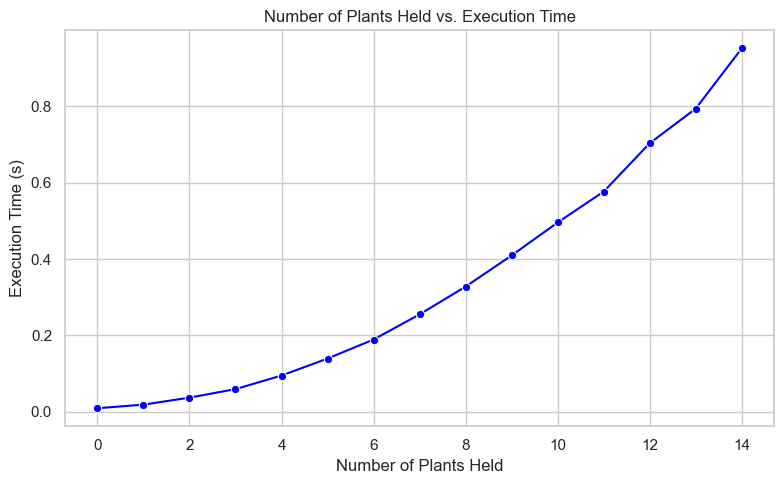

In [32]:
P = []
for j in range(0, 150):
    P.append((random.randint(1, 20), ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)], random.randint(1, 6), random.randint(1, 6)))
f = 100
Pmax = len(P)

xs = []
ys = []
n_trials = 10
for i in tqdm(range(0, 15)):
    avg = 0
    for j in range(n_trials):
        Pplayer = []
        for k in range(i):
            Pplayer.append((random.randint(1, 20), ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)], random.randint(1, 6), random.randint(1, 6)))
        
        start = time.time()
        phase1_purchase_power_plants(P, f, Pplayer, Pmax, ResourceCost, K)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Number of Plants Held vs. Execution Time")
ax.set_xlabel("Number of Plants Held")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

In [33]:
print(xs)
print(ys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0.00964958667755127, 0.019136643409729003, 0.037457633018493655, 0.059699416160583496, 0.0952756404876709, 0.13965466022491455, 0.18943185806274415, 0.25526268482208253, 0.3279534101486206, 0.4094733715057373, 0.4956384181976318, 0.5765374660491943, 0.7029776811599732, 0.7936027765274047, 0.9512535572052002]


## *Purchasing Resources*/*Building Connections*/*Powering Plants* Phase 

100%|████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 264.06it/s]


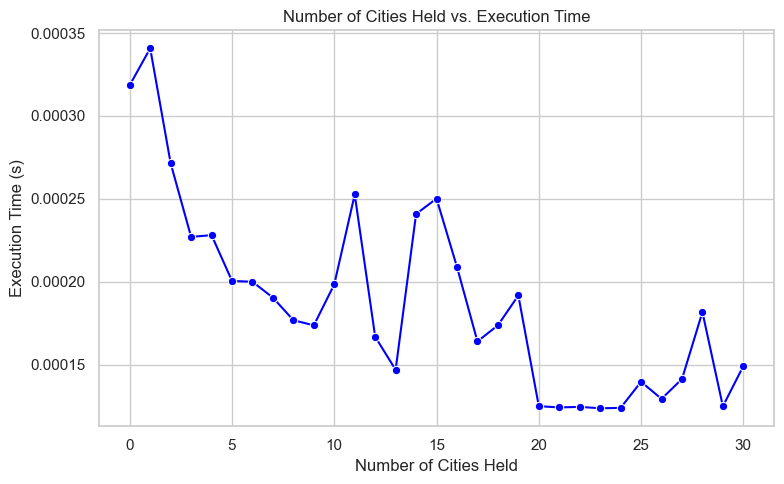

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.00031859874725341796, 0.00034077167510986327, 0.0002714395523071289, 0.00022710561752319335, 0.00022814273834228515, 0.00020053386688232422, 0.000200045108795166, 0.0001904606819152832, 0.0001768946647644043, 0.00017374753952026367, 0.00019849538803100585, 0.00025266408920288086, 0.00016685724258422852, 0.00014699697494506835, 0.00024089813232421874, 0.0002501964569091797, 0.00020895004272460937, 0.00016405582427978516, 0.000173795223236084, 0.00019180774688720703, 0.00012503862380981446, 0.00012428760528564452, 0.00012460947036743164, 0.00012378692626953126, 0.00012400150299072266, 0.00013977289199829102, 0.00012944936752319337, 0.00014140605926513672, 0.00018175840377807618, 0.0001249551773071289, 0.0001492023468017578]


In [41]:
G = nx.gnp_random_graph(30, 0.3)
for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(1, 20)

Gp, _ = phase0_solve_kmst(G, 30)
B = 1

xs = []
ys = []
max_c = len(G.nodes) + 1
n_trials = 20
for i in tqdm(range(0, max_c)):
    avg = 0
    for j in range(n_trials):
        start = time.time()
        phase2_purchase_build_power(P_player, Gp, list(G.nodes)[None:0:None][:i], f, ResourceCost, K, B)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Number of Cities Held vs. Execution Time")
ax.set_xlabel("Number of Cities Held")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

print(xs)
print(ys)

100%|███████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.53it/s]


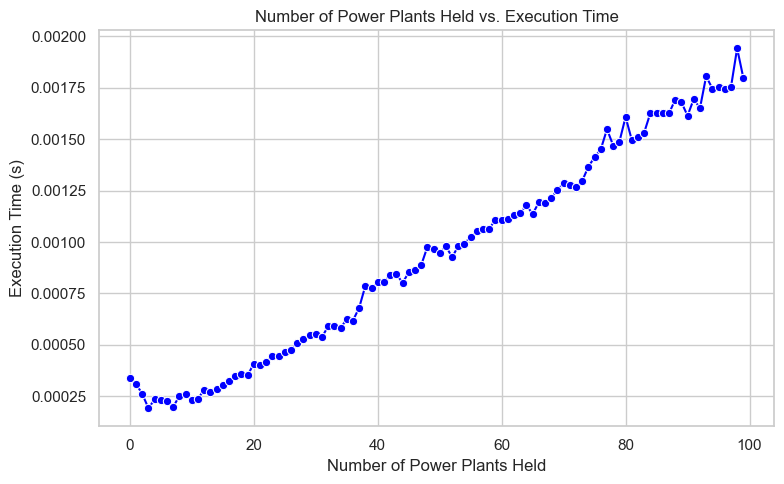

In [30]:
G = nx.gnp_random_graph(30, 0.3)
for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(1, 20)

Gp, _ = phase0_solve_kmst(G, 30)
B = 1

xs = []
ys = []
n_trials = 50
for i in tqdm(range(0, 100)):
    Pplayer = []
    for j in range(0, i + 1):
        Pplayer .append((random.randint(1, 20), ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)], random.randint(1, 6), random.randint(1, 6)))
    
    avg = []
    for j in range(n_trials):
        start = time.time()
        phase2_purchase_build_power(Pplayer, Gp, list(G.nodes)[None:0:None], f, ResourceCost, K, B)
        end = time.time()
        avg.append(end - start)

    avg = sorted(avg)
    subavg = avg[5:-5]
    
    xs.append(i)
    ys.append(sum(subavg) / len(subavg))

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Number of Power Plants Held vs. Execution Time")
ax.set_xlabel("Number of Power Plants Held")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

In [32]:
print(xs)
print(ys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.0003410816192626953, 0.0003106355667114258, 0.00026154518127441406, 0.0001922428607940674, 0.00023556947708129882, 0.0002300262451171875, 0.0002280294895172119, 0.00019936561584472657, 0.0002527475357055664, 0.0002639472484588623, 0.00023308396339416504, 0.00023851990699768065, 0.00028330087661743164, 0.0002730667591094971, 0.00028824806213378906, 0.00030308365821838377, 0.00032648444175720215, 0.0003512740135192871, 0.00035646557807922363, 0.0003525197505950928, 0.0004090726375579834, 0.0004022061824798584, 0.00041922926902770996, 0.0004479706287384033, 0.0004467129707336426, 0.0004669010639190674,

100%|█████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 40.15it/s]


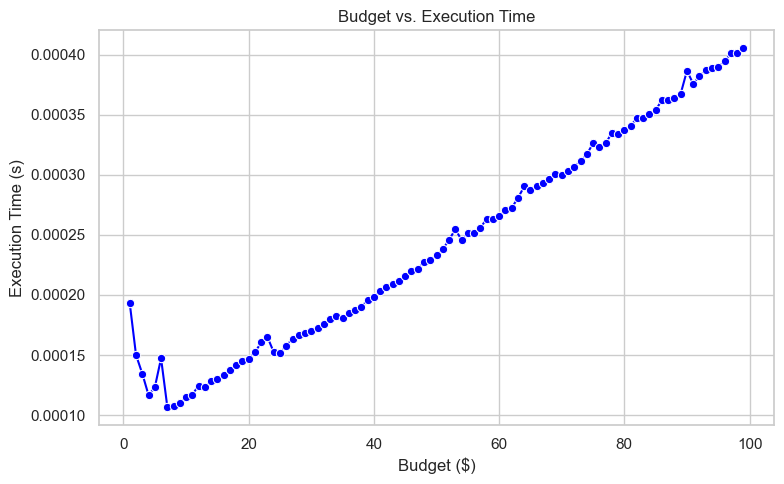

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.0001930147409439087, 0.00015001893043518067, 0.00013449490070343016, 0.00011663734912872314, 0.00012303590774536132, 0.00014719963073730468, 0.0001068413257598877, 0.00010783076286315917, 0.00011042654514312745, 0.00011473596096038819, 0.00011706650257110595, 0.00012452304363250733, 0.0001237243413925171, 0.00012815296649932862, 0.0001298844814300537, 0.00013369321823120117, 0.00013747215270996094, 0.00014133751392364502, 0.00014471113681793212, 0.00014686286449432372, 0.00015225112438201904, 0.00016052722930908202, 0.00016477704048156738, 0.00015239417552947998, 0.0001514643430709839, 0.00015785992145

In [66]:
G = nx.gnp_random_graph(30, 0.3)
for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(1, 20)

Gp, _ = phase0_solve_kmst(G, 30)
B = 1

Pplayer = []
for j in range(0, 10):
    Pplayer.append((random.randint(1, 20), ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)], random.randint(1, 6), random.randint(1, 6)))

xs = []
ys = []
n_trials = 100
for f in tqdm(range(1, 100)):
    avg = []
    for j in range(n_trials):
        start = time.time()
        phase2_purchase_build_power(Pplayer, Gp, list(G.nodes)[None:0:None], f, ResourceCost, K, B)
        end = time.time()
        avg.append(end - start)

    avg = sorted(avg)
    subavg = avg[10:-10]
    
    xs.append(f)
    ys.append(sum(subavg) / len(subavg))

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Budget vs. Execution Time")
ax.set_xlabel("Budget ($)")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

print(xs)
print(ys)

100%|█████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 75.08it/s]


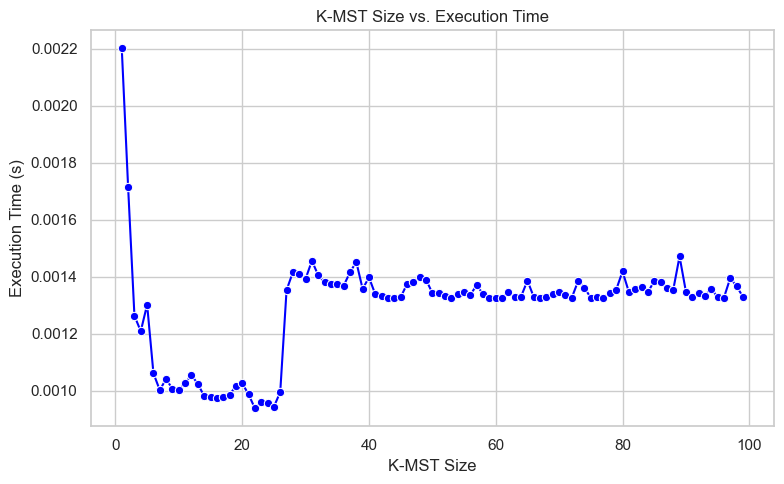

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.002200643221537272, 0.0017153422037760417, 0.0012626250584920247, 0.001208941141764323, 0.001301884651184082, 0.0010609626770019531, 0.001002351442972819, 0.001042008399963379, 0.0010056495666503906, 0.0010024309158325195, 0.0010276238123575847, 0.0010538101196289062, 0.001024762789408366, 0.0009808142979939778, 0.000976840655008952, 0.0009749730428059896, 0.0009764830271402994, 0.0009856224060058594, 0.0010166565577189128, 0.0010263919830322266, 0.0009875297546386719, 0.0009387334187825521, 0.0009616613388061523, 0.0009559790293375651, 0.0009440183639526367, 0.000995318094889323, 0.0013529856999715169

In [76]:
G = nx.gnp_random_graph(100, 0.3)
for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(1, 20)

Gp, _ = phase0_solve_kmst(G, 100)
B = 1

Pplayer = []
for j in range(0, 10):
    Pplayer.append((random.randint(1, 20), ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)], random.randint(1, 6), random.randint(1, 6)))

xs = []
ys = []
n_trials = 10
for K in tqdm(range(1, 100)):
    avg = []
    for j in range(n_trials):
        start = time.time()
        phase2_purchase_build_power(Pplayer, Gp, list(G.nodes)[None:0:None], 100, ResourceCost, K, B)
        end = time.time()
        avg.append(end - start)

    avg = sorted(avg)
    subavg = avg[2:-2]
    
    xs.append(K)
    ys.append(sum(subavg) / len(subavg))

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("K-MST Size vs. Execution Time")
ax.set_xlabel("K-MST Size")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

print(xs)
print(ys)